this script calculate the publication reduction of countries and visualize the results.the input of the script is:
- raw_path: number of publication of countries in each year and discipline assigned by full counting
- filter_path: publication record after removing based on specific rules (e.g. removing funding-exchange pub).
- geopath: shp file for world map plot
- region_path: country-region information

The output of the script is:
- the worldmap with countries colored by the proportion of reduction
- the aggregated boxplot with same result

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import funding.core
import seaborn as sns

In [2]:
cntry_full_path="../../data/nf_folder/Data/DerivedData/Derived/cntry_author_full.csv"
cntry_filter_path='../../data/nf_folder/Data/DerivedData/Derived/dep-FundInternational/pub_noInt_fund.csv'
geopath="../../data/nf_folder/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp"
region_path="../../data/nf_folder/Data/AdditionalData/cntry_region.xlsx"

plot_path="/u/miaoli/ember_home/dropbox/NationalFunding/Figs/Figs/dep-FundInternational/pub_reduction_global.pdf"

In [3]:
# Parameters
cntry_full_path = (
    "../data/NationalFunding/Data/DerivedData/Derived/cntry_author_full.csv"
)
cntry_filter_path = (
    "../data/NationalFunding/Data/DerivedData/Derived/dependence/pub_noint_fund.csv"
)
geopath = "../data/NationalFunding/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp"
region_path = "../data/NationalFunding/Data/AdditionalData/cntry_region.xlsx"
plot_path = "../data/NationalFunding/Figs/Figs/dependence_NoForeignFund/pub_reduction_global.pdf"


In [4]:
raw_df=pd.read_csv(cntry_full_path)
raw_df.head()

,cntry,year,dis,count
0,Afghanistan,2009,3,1
1,Afghanistan,2009,33,1
2,Afghanistan,2009,35,1
3,Afghanistan,2009,44,2
4,Afghanistan,2009,47,1


In [5]:
filter_df=pd.read_csv(cntry_filter_path)
filter_df.head()

,cntry,year,dis,count
0,Afghanistan,2009,3,1
1,Afghanistan,2009,33,1
2,Afghanistan,2009,44,2
3,Afghanistan,2009,47,1
4,Afghanistan,2009,52,1


In [6]:
cnt=raw_df.merge(filter_df,on=['cntry','year','dis'],suffixes=('_raw', '_filter'),how='left')
cnt=cnt.fillna(0)
cnt=cnt.groupby(['cntry']).agg({'count_raw':'sum',
                              'count_filter':'sum'})

In [7]:
cnt['prop']=(cnt['count_raw']-cnt['count_filter'])/(cnt['count_raw'])

In [8]:
test = cnt.reset_index()
test[test.cntry.isin(['United States','France','Germany','United Kingdom'])]

,cntry,count_raw,count_filter,prop
63,France,662787,405808.0,0.387725
69,Germany,930931,580307.0,0.376638
195,United Kingdom,890670,499939.0,0.438693
196,United States,3208809,2425466.0,0.244123


In [9]:
region_df=pd.read_excel(region_path)[['cntry','region2']].drop_duplicates()
region_df=region_df.replace(to_replace={'region2':{'EU':'Europe','Other Europe':'Europe'}})
region_df.head()

,cntry,region2
0,Algeria,Africa
1,Angola,Africa
2,Belgian Congo,Africa
3,Benin,Africa
4,Botswana,Africa


In [10]:
cnt=cnt.reset_index().merge(region_df,on='cntry',how='left')
cnt=cnt.dropna() #drop antarctica

In [11]:
world_geo=funding.core.read_geofile(geopath)
world_geo.head(2)

,WoS,Code,geometry
0,Zimbabwe,ZWE,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,ZMB,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."


In [12]:
cnt.sort_values(by='prop')

,cntry,count_raw,count_filter,prop,region2
84,Iran,262216,244118.0,0.069019,Asia
189,Turkey,241651,217383.0,0.100426,Europe
38,China,2365486,2089836.0,0.116530,Asia
82,India,546865,482187.0,0.118271,Asia
169,South Korea,490587,417823.0,0.148320,Asia
...,...,...,...,...,...
76,Guinea-Bissau,333,60.0,0.819820,Africa
200,Vatican,202,35.0,0.826733,Europe
158,Sao Tome & Principe,36,5.0,0.861111,Africa
134,Niue,5,0.0,1.000000,Oceania


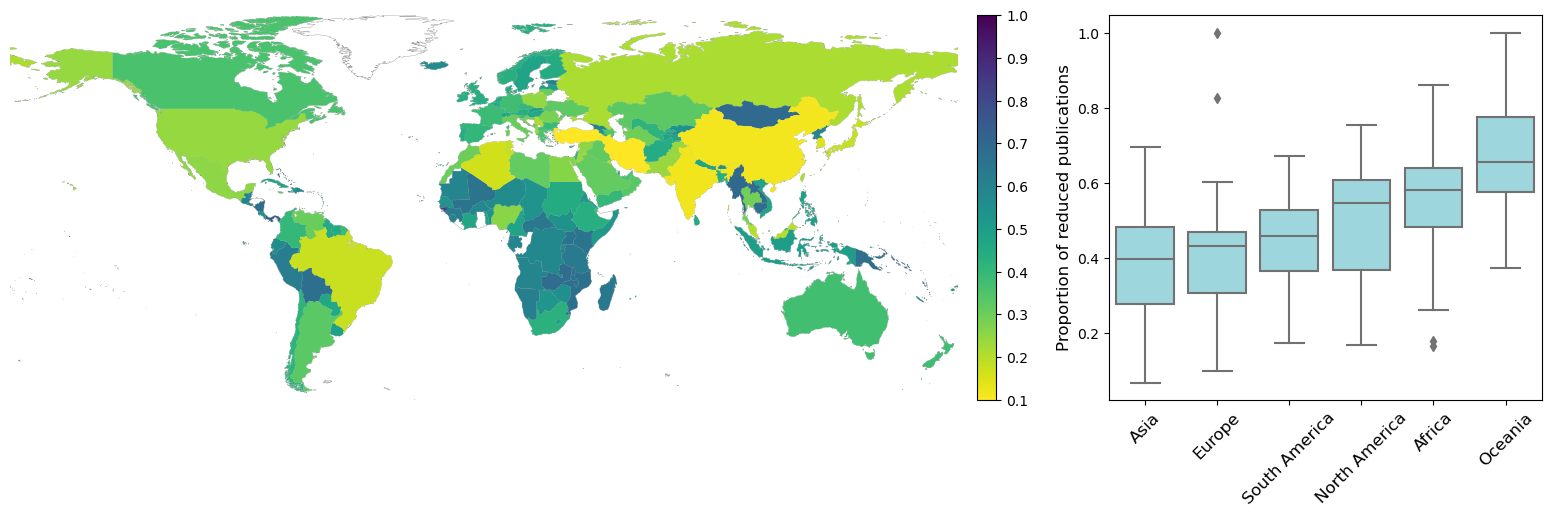

In [13]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [70, 30],'wspace': 0.15},figsize=(20,5))
plot_data=world_geo.merge(cnt[['cntry','prop']],left_on='WoS',right_on='cntry')
plot_data=gp.GeoDataFrame(plot_data)
funding.core.plot_worldmap(ax[0], fig, world_geo, plot_data, 'prop','viridis_r',0.1,1)
ax[0].margins(0)

orders=['Asia','Europe','South America','North America','Africa','Oceania']
sns.boxplot(x='region2',y='prop',data=cnt,color='#92DFE6',
            order=orders,ax=ax[1])
ax[1].set_ylabel('Proportion of reduced publications',fontsize=12)
ax[1].set_xlabel('')
ax[1].set_xticklabels(orders,rotation=45,fontsize=12)
plt.savefig(plot_path,bbox_inches='tight')